<a href="https://colab.research.google.com/github/DinhLuan14/SA-SOCIAL-MEDIA-TEXT/blob/main/ViCTSD-Deep-learning-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jul  1 05:04:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!gdown --id 1fnwwTiBzfPogBAHnc9C5beJbt7fbNNqY
!gdown --id 1q4KOoYB6N44oTJlk6SpeQlTinTwCLg41
!gdown --id 1eoDiU22TVy7LLAOzDAsq3v5BsHTYPWPI
!pip install underthesea

Downloading...
From: https://drive.google.com/uc?id=1fnwwTiBzfPogBAHnc9C5beJbt7fbNNqY
To: /content/UIT-ViCTSD_train.json
2.46MB [00:00, 78.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1q4KOoYB6N44oTJlk6SpeQlTinTwCLg41
To: /content/UIT-ViCTSD_dev.json
100% 715k/715k [00:00<00:00, 11.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eoDiU22TVy7LLAOzDAsq3v5BsHTYPWPI
To: /content/UIT-ViCTSD_test.json
100% 349k/349k [00:00<00:00, 5.52MB/s]
     |████████████████████████████████| 7.5MB 34.9MB/s 
     |████████████████████████████████| 245kB 51.7MB/s 
     |████████████████████████████████| 753.2MB 23kB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 747kB 45.5MB/s 
     |████████████████████████████████| 1.3MB 44.6MB/s 
     |████████████████████████████████| 2.9MB 42.8MB/s 
     |████████████████████████████████| 1.1MB 44.0MB/s 
     |████████████████████████████████| 901kB 43.1MB/s 
  Created wheel for seqeval: filena

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import keras

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# LOAD DATA
# Train set
df = pd.read_json('/content/UIT-ViCTSD_train.json')
df = df.rename(columns={'comment': 'Comment', 'constructiveness': 'Constructiveness', 'toxicity': 'Toxicity'})
train_Constructiveness_df = df[["Comment", "Constructiveness"]]
train_Toxicity_df = df[["Comment", "Toxicity"]]

# Dev set
df = pd.read_json('/content/UIT-ViCTSD_dev.json')
df = df.rename(columns={'comment': 'Comment', 'constructiveness': 'Constructiveness', 'toxicity': 'Toxicity'})
val_Constructiveness_df = df[["Comment", "Constructiveness"]]
val_Toxicity_df = df[["Comment", "Toxicity"]]

# Test set
df = pd.read_json('/content/UIT-ViCTSD_test.json')
df = df.rename(columns={'comment': 'Comment', 'constructiveness': 'Constructiveness', 'toxicity': 'Toxicity'})
test_Constructiveness_df = df[["Comment", "Constructiveness"]]
test_Toxicity_df = df[["Comment", "Toxicity"]]

In [ ]:
train_Constructiveness_df

,Comment,Constructiveness
0,Thật tuyệt vời...!!!,0
1,"mỹ đã tuột dốc quá nhiều rồi, giờ muốn vực dậy...",1
2,tôi thấy người lái xe hơi bấm còi mới là người...,1
3,Coi dịch là giặc. Đã mang tên đó mà xâm nhập V...,0
4,Thương các bé quá! Các con còn quá nhỏ mà đã p...,0
...,...,...
6995,"đọc tin mà đau lòng quá,thảm nạn cứ xãy ra hoà...",0
6996,Nên mua bạn nhé. Để bảo vệ sức khỏe bạn trong ...,1
6997,Nên ra luật người sử dụng ma túy cũng phạm tội...,1
6998,Mua Fadil đủ lăn bánh. Nếu thấy đắt thì đi Mor...,1


In [ ]:
val_Constructiveness_df

,Comment,Constructiveness
0,Cuộc bầu cư người đứng đầu Quốc gia ở Mỹ là cô...,0
1,Mình thích Messi ở lại để Barca và Cules hiểu ...,1
2,"dám chui ra,vậy ăn vô lại ếch said :')",0
3,Hoan hô sự quả cảm của các chiến sĩ và sự đồng...,0
4,Tôi cực lực phản đối cho hs dùng đt trong lớp ...,0
...,...,...
1995,Tôi có con đã học lớp 1 năm học 2019-2020. Tôi...,1
1996,Hình ảnh làm tôi nhớ ngày xưa ra cánh đồng chặ...,0
1997,Chúc mừng các anh!,0
1998,Bộ Y Tế cần nhắn tin đến toàn bộ số điện thoại...,0


In [ ]:
test_Constructiveness_df

,Comment,Constructiveness
0,Người ăn không hết kẻ lần chẳng ra,0
1,Nhiều người cứ nghĩ đạp xe là văn minh. haizzzz,0
2,Rất văn hoá,0
3,Đời ta ba mươi đời nó. Mua chiếc xe cũng chỉ p...,0
4,"Tước bằng lái vĩnh viễn đi. Chạy lếu láo thật,...",1
...,...,...
995,biệt thự nhà riêng to đùng thế kia mà chủ (hay...,0
996,"Trong cái khó ló cái khôn, người tài thật sự k...",0
997,Bánh trung thu sao lại phải có quả trứng muối ...,0
998,Cấp 1 nói chung và lớp 1 nói riêng theo tôi có...,1


# **I. DATA PREPARATION**








## 1.Remove punctuation







In [ ]:
import string
def cleaner_update(text):
    return text.translate(str.maketrans('','', string.punctuation))
    # return text

def get_clean_sents(df):
  clean_sents = []
  for i in range(len(df)):
    clean_sents.append(cleaner_update(df['Comment'][i]))
  return clean_sents

clean_x_train = get_clean_sents(train_Constructiveness_df)
clean_x_dev = get_clean_sents(val_Constructiveness_df)
clean_x_test = get_clean_sents(test_Constructiveness_df)

In [ ]:
clean_x_train[:10]

['Thật tuyệt vời',
 'mỹ đã tuột dốc quá nhiều rồi giờ muốn vực dậy cũng rất khó',
 'tôi thấy người lái xe hơi bấm còi mới là người rất\x1c lịch sự quá văn minhđường xá là của chungngười cùng sử dụng kiên nhẫn cùng nhau dùng bấm còi nháy đèn đòi ưu tiên tôi phải được đi trước thật quá là anh đại mà',
 'Coi dịch là giặc Đã mang tên đó mà xâm nhập VN thì phải đầu hàng hoặc cút xéo VN luôn tự hào',
 'Thương các bé quá Các con còn quá nhỏ mà đã phải sớm rời xa cha mẹ Xin chia buồn cùng các gia đình các con cầu mong các con thật vui ở thế giới mới',
 'Sevila đoạt cúp sau loạt đá luân lưu nha',
 'Angelina Jolie có đôi bàn tay nổi gân guốc quá',
 'Tôi không biết bà ấy làm thế nào để xử lý gã ấy chỉ thấy đánh bùm bùm',
 'tấm hình này chắc bộ nhớ máy tính chứa được 1 tấm',
 'Không trung sẽ không còn yên tĩnh']

## 2.Tokenize Words

In [ ]:
from underthesea import word_tokenize
tokenized_clean_x_train = []
tokenized_clean_x_dev = []
tokenized_clean_x_test = []
for x in clean_x_train:
    sentence = "-".join(word_tokenize(x))
    tokenized_clean_x_train.append(sentence)
for x in clean_x_dev:
    sentence = "-".join(word_tokenize(x))
    tokenized_clean_x_dev.append(sentence)
for x in clean_x_test:
    sentence = "-".join(word_tokenize(x))
    tokenized_clean_x_test.append(sentence)

In [ ]:
tokenized_clean_x_train

['Thật-tuyệt vời',
 'mỹ-đã-tuột-dốc-quá-nhiều-rồi-giờ-muốn-vực-dậy-cũng-rất-khó',
 'tôi-thấy-người-lái-xe hơi-bấm-còi-mới-là-người-rất-lịch sự-quá-văn-minhđường-xá-là-của-chungngười-cùng-sử dụng-kiên nhẫn-cùng-nhau-dùng-bấm-còi-nháy-đèn-đòi-ưu tiên-tôi-phải-được-đi-trước-thật-quá-là-anh-đại-mà',
 'Coi-dịch-là-giặc-Đã-mang-tên-đó-mà-xâm nhập-VN-thì-phải-đầu hàng-hoặc-cút-xéo-VN-luôn-tự hào',
 'Thương-các-bé-quá-Các-con-còn-quá-nhỏ-mà-đã-phải-sớm-rời-xa-cha mẹ-Xin-chia buồn-cùng-các-gia đình-các-con-cầu mong-các-con-thật-vui-ở-thế giới-mới',
 'Sevila-đoạt-cúp-sau-loạt-đá-luân lưu-nha',
 'Angelina-Jolie-có-đôi-bàn tay-nổi gân guốc-quá',
 'Tôi-không-biết-bà-ấy-làm-thế nào-để-xử lý-gã-ấy-chỉ-thấy-đánh-bùm-bùm',
 'tấm-hình-này-chắc-bộ nhớ-máy tính-chứa-được-1-tấm',
 'Không trung-sẽ-không-còn-yên tĩnh',
 'Dí-súng-vào-người-khác-bóp cò-đạn-ko-nổ-ko-thuộc-trường hợp-có-tính-côn đồ-Bó tay-luônĐề nghị-giảm-án-cho-anh-Đi',
 'Em-quá-giỏi-Em-nên-tham gia-THÀNH LẬP-CLB-tiếng-Anh-Ở-các-Giáo xứ-nhà chù

Convert it back to pd.Series

In [ ]:
x_train = pd.Series(tokenized_clean_x_train)
x_val = pd.Series(tokenized_clean_x_dev)
x_test = pd.Series(tokenized_clean_x_test)

## 3.Training build_vocav with 2 method of skipgam and CBOW


In [ ]:
def simple_tokenizer(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split("-"), [prefix + '_%s' % i]))
    return result

In [ ]:
# all_x = pd.concat([x_train]).append(pd.concat([x_val])).append(pd.concat([x_test]))
all_x = pd.concat([x_train]).append(pd.concat([x_val]))
all_x_w2v = simple_tokenizer(all_x, 'all')

In [ ]:
all_x_w2v[:10]

[TaggedDocument(words=['Thật', 'tuyệt vời'], tags=['all_0']),
 TaggedDocument(words=['mỹ', 'đã', 'tuột', 'dốc', 'quá', 'nhiều', 'rồi', 'giờ', 'muốn', 'vực', 'dậy', 'cũng', 'rất', 'khó'], tags=['all_1']),
 TaggedDocument(words=['tôi', 'thấy', 'người', 'lái', 'xe hơi', 'bấm', 'còi', 'mới', 'là', 'người', 'rất', 'lịch sự', 'quá', 'văn', 'minhđường', 'xá', 'là', 'của', 'chungngười', 'cùng', 'sử dụng', 'kiên nhẫn', 'cùng', 'nhau', 'dùng', 'bấm', 'còi', 'nháy', 'đèn', 'đòi', 'ưu tiên', 'tôi', 'phải', 'được', 'đi', 'trước', 'thật', 'quá', 'là', 'anh', 'đại', 'mà'], tags=['all_2']),
 TaggedDocument(words=['Coi', 'dịch', 'là', 'giặc', 'Đã', 'mang', 'tên', 'đó', 'mà', 'xâm nhập', 'VN', 'thì', 'phải', 'đầu hàng', 'hoặc', 'cút', 'xéo', 'VN', 'luôn', 'tự hào'], tags=['all_3']),
 TaggedDocument(words=['Thương', 'các', 'bé', 'quá', 'Các', 'con', 'còn', 'quá', 'nhỏ', 'mà', 'đã', 'phải', 'sớm', 'rời', 'xa', 'cha mẹ', 'Xin', 'chia buồn', 'cùng', 'các', 'gia đình', 'các', 'con', 'cầu mong', 'các', 'con',

In [ ]:
cores = multiprocessing.cpu_count()
print("cores = ", cores)
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)

cores =  2


In [ ]:
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 9000/9000 [00:00<00:00, 1225091.23it/s]


In [ ]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                        total_examples=len(all_x_w2v),
                        epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 9000/9000 [00:00<00:00, 1453159.95it/s]


CPU times: user 13.4 s, sys: 117 ms, total: 13.6 s
Wall time: 7.61 s


In [ ]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 9000/9000 [00:00<00:00, 996192.86it/s]


In [ ]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                      total_examples=len(all_x_w2v),
                      epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 9000/9000 [00:00<00:00, 1791246.84it/s]


CPU times: user 24.7 s, sys: 131 ms, total: 24.8 s
Wall time: 13.4 s


Save results

In [ ]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

Get Keyed Vectors

In [ ]:
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

Appending cbow and sg for better result

In [ ]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 8723 word vectors.


In [ ]:
np.append(model_ug_cbow.wv['mỹ'],model_ug_sg.wv['mỹ'])

array([-1.3306754 , -0.09387633,  0.8655698 ,  0.11398467,  0.5950679 ,
       -0.4991839 ,  0.14194909, -0.15633124, -1.0989566 , -0.34645873,
        0.2362935 ,  0.4159164 , -0.73993886, -0.07193936, -0.12161655,
        1.3174136 ,  0.42005786,  0.6260152 ,  0.13410297,  1.2591621 ,
        0.09843727, -1.259738  , -0.32884616,  1.4165642 , -0.15671979,
       -0.85526663, -1.1678516 ,  0.10261323,  0.09792206, -0.23785175,
       -0.5161655 ,  1.609039  ,  0.8709645 ,  0.24562037,  0.78538024,
        0.39896062,  0.8162546 ,  0.72990704, -0.0364325 ,  0.36879033,
       -1.7096688 , -0.03376946, -0.19520706,  0.15687731,  0.99974674,
        0.3632448 ,  0.5729501 ,  1.5038017 , -0.73178065, -1.4084015 ,
        1.4831954 , -1.4961547 , -1.7584114 ,  0.23922615, -0.9046383 ,
        1.1916947 ,  0.04628988,  0.16904055,  0.96069926,  1.2744772 ,
        1.0066892 , -0.8570423 , -0.16530536, -1.8475525 , -0.00570273,
       -0.24799734, -0.17196612,  0.88878894,  0.4823952 , -0.59

## 4.Vectorize words into numberic

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~ ')
tokenizer.fit_on_texts(x_train)

In [ ]:
sequences_train = tokenizer.texts_to_sequences(x_train)

In [ ]:
def get_length(series):
  length = []
  for x in series:
      length.append(len(x.split()))
  return max(length)

In [ ]:
print(get_length(x_train))
print(get_length(x_val))
print(get_length(x_test))

79
67
57


In [ ]:
MAX_LENGTH = 80

In [ ]:
x_train_seq = pad_sequences(sequences_train, maxlen=MAX_LENGTH)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (7000, 80)


In [ ]:
for data_point in x_val_seq:
  print(data_point)

Streaming output truncated to the last 5000 lines.
   54  273  710  212  201 2249 2242    5 1957  341    4    3    1   51
  222   85   33    1  346   66  643 1091 1489  526  890   90  404   40
   44    1  151   12  658  251  223    8  162  286]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  404    3   21    2  417  165
   36  989   10    2 1007 2055   52  107   65   19]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  497  134  257  367 2263   39   43  484  635
   86   35   39 1376   19 2191   19  236  212  497  134  727  22

In [ ]:
sequences_val = tokenizer.texts_to_sequences(x_val)
x_val_seq = pad_sequences(sequences_val, maxlen=MAX_LENGTH)
print('Shape of data tensor:', x_val_seq.shape)

Shape of data tensor: (2000, 80)


In [ ]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=MAX_LENGTH)
print('Shape of data tensor:', x_test_seq.shape)

Shape of data tensor: (1000, 80)


In [ ]:
num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.58388764, -0.37885475, -0.18342476, ...,  0.15321779,
        -0.08227002, -0.08884064],
       [ 0.37491462, -0.88633752,  0.49796116, ...,  0.45194456,
         0.07303435,  0.26043531],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## 5.Process labels

In [ ]:
train_Constructiveness_df.Constructiveness.value_counts()

0    4497
1    2503
Name: Constructiveness, dtype: int64

In [ ]:
train_Toxicity_df.Toxicity.value_counts()

0    6241
1     759
Name: Toxicity, dtype: int64

In [ ]:
NUM_CLASSES = 2

In [ ]:
from keras.utils.np_utils import to_categorical

labels_train_Constructiveness = to_categorical(train_Constructiveness_df.Constructiveness, num_classes=NUM_CLASSES)
labels_val_Constructiveness = to_categorical(val_Constructiveness_df.Constructiveness, num_classes=NUM_CLASSES)
labels_test_Constructiveness = to_categorical(test_Constructiveness_df.Constructiveness, num_classes=NUM_CLASSES)

labels_train_Toxicity = to_categorical(train_Toxicity_df.Toxicity, num_classes=NUM_CLASSES)
labels_val_Toxicity = to_categorical(val_Toxicity_df.Toxicity, num_classes=NUM_CLASSES)
labels_test_Toxicity = to_categorical(test_Toxicity_df.Toxicity, num_classes=NUM_CLASSES)

In [ ]:
labels_train_Constructiveness[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# **II.TRAINING MODEL**

## 1.Pre-training

In [ ]:
# imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Activation
from keras.models import Model
from keras.optimizers import RMSprop
from keras.optimizers import Adam

from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GRU

import sklearn.metrics as metrics
from sklearn.metrics import classification_report

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def show_results_on_test(MODEL, x_test_seq, labels_test):
  test_loss, test_accuracy, f1_m, precision_m, recall_m = MODEL.evaluate(x_test_seq,
                                                                         labels_test,
                                                                         verbose=0)
  print("test_loss", test_loss)
  print("test_accuracy", test_accuracy)
  print("f1_m", f1_m)
  print("precision_m", precision_m)
  print("recall_m", recall_m)

  x_test_seq = x_test_seq.tolist()

In [ ]:
def plot_confusion_matrix(matrix, num_classes):
  df_cm = pd.DataFrame(matrix, index = [i for i in range(num_classes)],
                    columns = [i for i in range(num_classes)])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
def oneHotVector_to_list(oneHotLabel):
  out_list = list()
  for row in oneHotLabel:
    row_as_list = row.tolist()
    row_as_list = [round(x) for x in row_as_list]
    # print(row_as_list)
    if 1 in row_as_list:
      out_list.append(row_as_list.index(1))
    else:
      out_list.append(0)
  return out_list

In [ ]:
def inference(MODEL, x_test_seq, labels_test):
  y_pred = MODEL.predict(x_test_seq)

  y_pred = oneHotVector_to_list(y_pred)
  y_true = oneHotVector_to_list(labels_test)

  return y_true, y_pred

In [ ]:
def single_inference(MODEL, MAX_LENGTH=MAX_LENGTH):
  sentence = input("Nhập câu: ")
  sentence_series = pd.Series(sentence)

  sentence_sequence = tokenizer.texts_to_sequences(sentence_series)
  sentence_sequence = pad_sequences(sentence_sequence, maxlen=MAX_LENGTH)
  one_hot_label = MODEL.predict(sentence_sequence)
  label = oneHotVector_to_list(one_hot_label)
  print("Label của câu này là: ", label[0])

## 2.Train Constructiveness

### CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 79, 64)            25664     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2496)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                159808    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

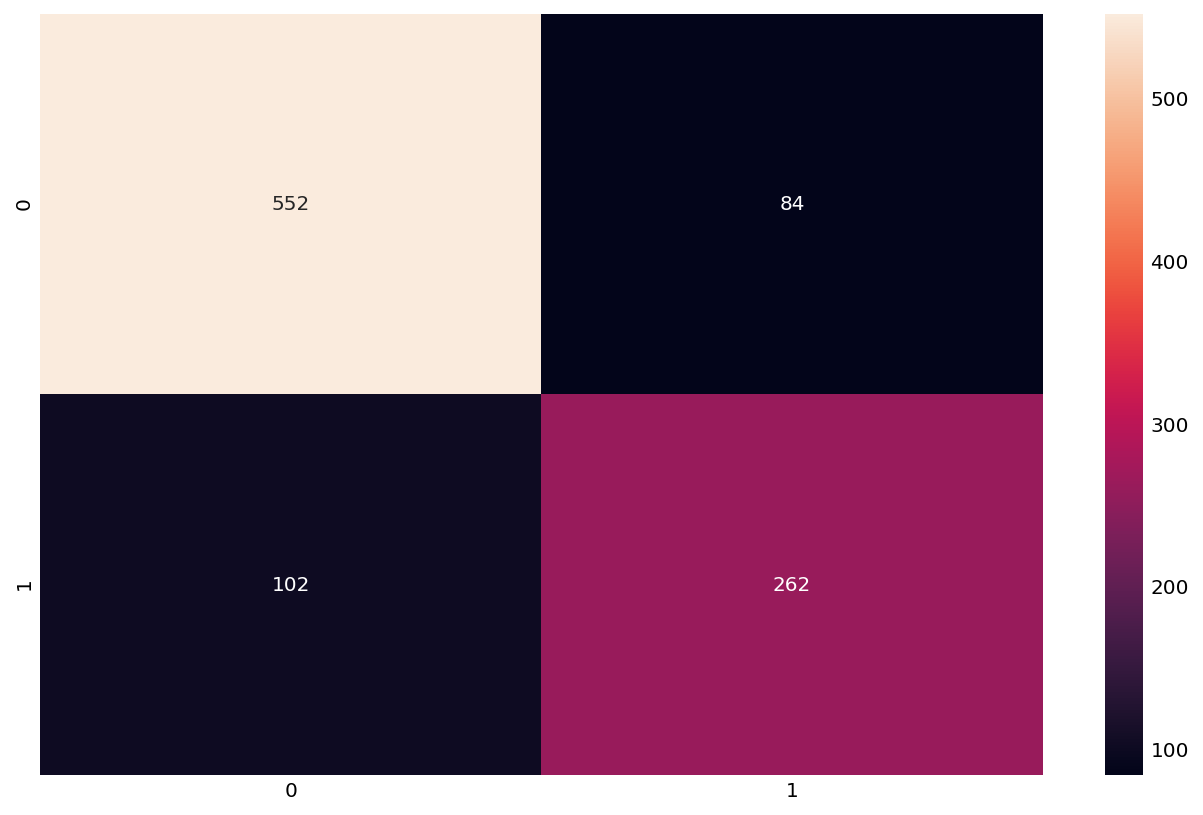

In [ ]:
# Model
model_CNN = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_CNN.add(e)

model_CNN.add(Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu', strides=1))
model_CNN.add(MaxPooling1D())

model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.8))

model_CNN.add(Dense(NUM_CLASSES, activation='softmax'))

model_CNN.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_CNN.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_CNN
history = MODEL.fit(x_train_seq, labels_train_Constructiveness,
                    validation_data=(x_val_seq, labels_val_Constructiveness),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Constructiveness)
print("")

y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Constructiveness.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Constructiveness)
print(classification_report(y_true, y_pred, digits = 4))

### LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 200)           2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 2,072,130
Trainable params: 2,072,130
Non-trainable params: 0
____________________________________________

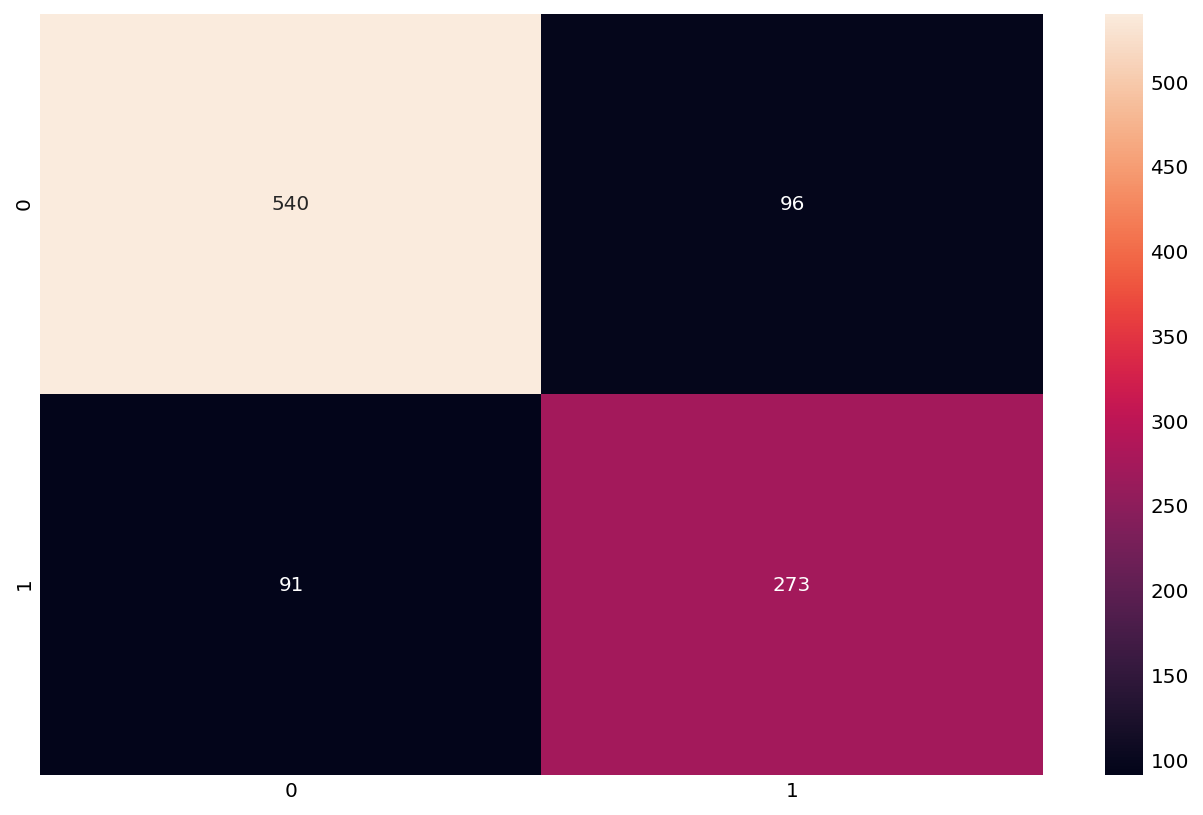

In [ ]:
# Model
model_LSTM = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_LSTM.add(e)

model_LSTM.add(LSTM(64))

model_LSTM.add(Flatten())
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dropout(0.8))

model_LSTM.add(Dense(NUM_CLASSES, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_LSTM.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_LSTM
history = MODEL.fit(x_train_seq, labels_train_Constructiveness,
                    validation_data=(x_val_seq, labels_val_Constructiveness),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Constructiveness)
print("")
y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Constructiveness.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Constructiveness)
print(classification_report(y_true, y_pred, digits = 4))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 200)           2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               135680    
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 2,144,066
Trainable params: 2,144,066
Non-trainable params: 0
____________________________________________

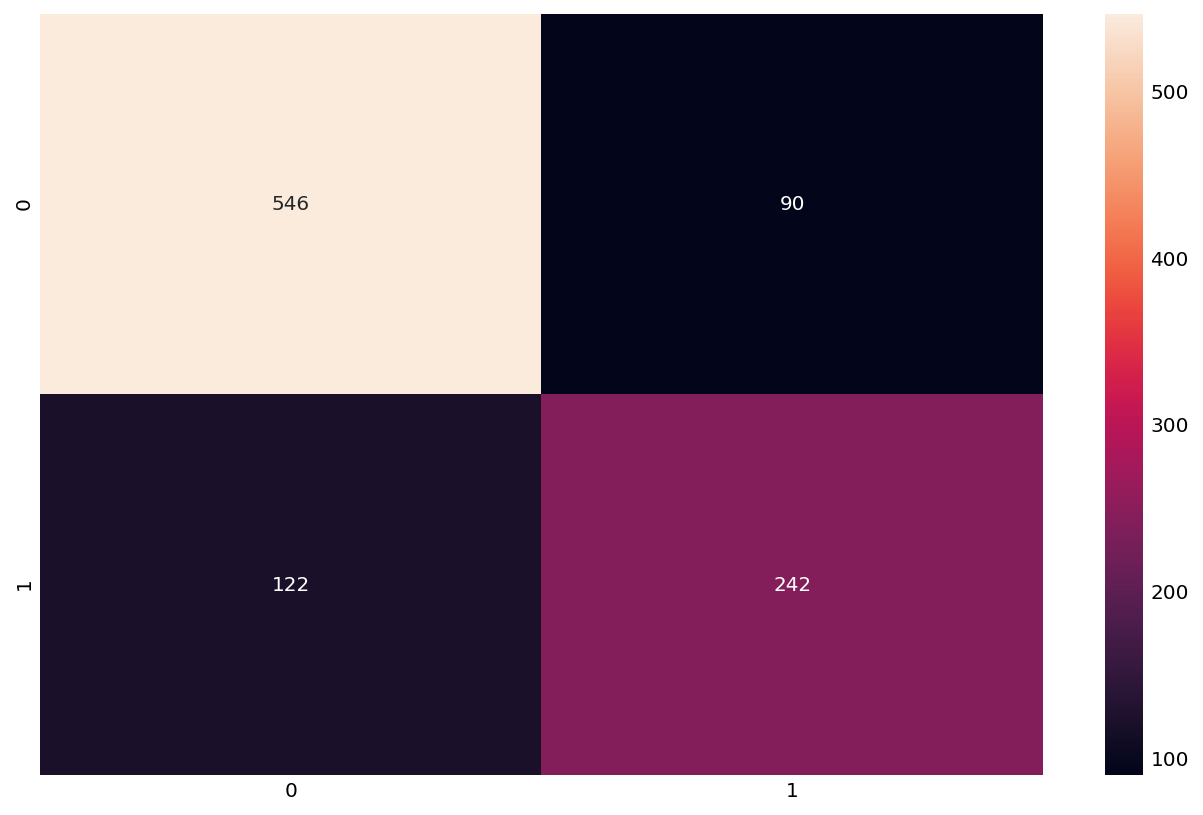

In [ ]:
# model_BiLSTM
model_BiLSTM = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_BiLSTM.add(e)

model_BiLSTM.add(Bidirectional(LSTM(64)))
model_BiLSTM.add(Flatten())

model_BiLSTM.add(Dense(64, activation='relu'))
model_BiLSTM.add(Dropout(0.8))

model_BiLSTM.add(Dense(NUM_CLASSES, activation='softmax'))

model_BiLSTM.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_BiLSTM.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_BiLSTM
history = MODEL.fit(x_train_seq, labels_train_Constructiveness,
                    validation_data=(x_val_seq, labels_val_Constructiveness),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Constructiveness)
print("")
y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Constructiveness.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Constructiveness)
print(classification_report(y_true, y_pred, digits = 4))

### GRU

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 200)           2000000   
_________________________________________________________________
gru (GRU)                    (None, 64)                51072     
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 2,055,362
Trainable params: 2,055,362
Non-trainable params: 0
____________________________________________

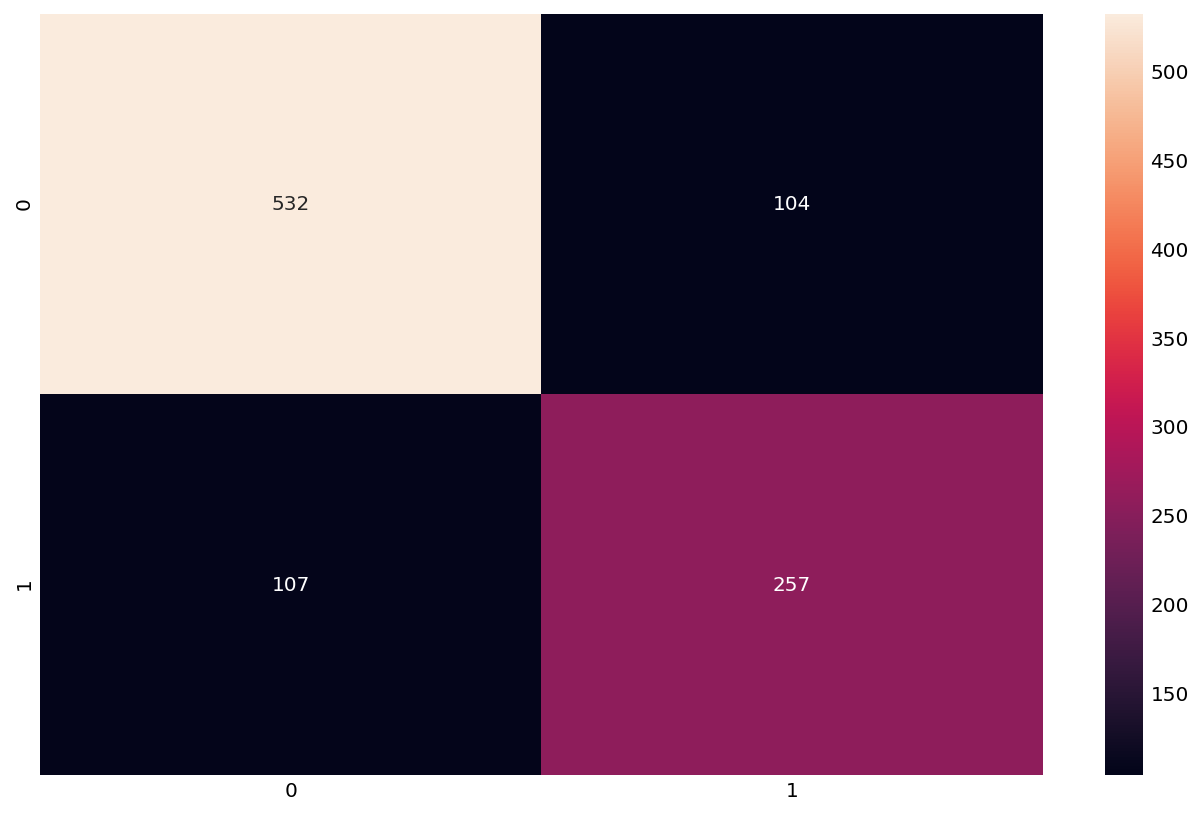

In [ ]:
# model_GRU
model_GRU = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_GRU.add(e)

model_GRU.add(GRU(64))
model_GRU.add(Flatten())

model_GRU.add(Dense(64, activation='relu'))
model_GRU.add(Dropout(0.8))

model_GRU.add(Dense(NUM_CLASSES, activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_GRU.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_GRU
history = MODEL.fit(x_train_seq, labels_train_Constructiveness,
                    validation_data=(x_val_seq, labels_val_Constructiveness),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Constructiveness)
print("")
y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Constructiveness.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Constructiveness)
print(classification_report(y_true, y_pred, digits = 4))

## 3.Train Toxicity

### CNN

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 200)           2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 79, 64)            25664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2496)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                159808    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                

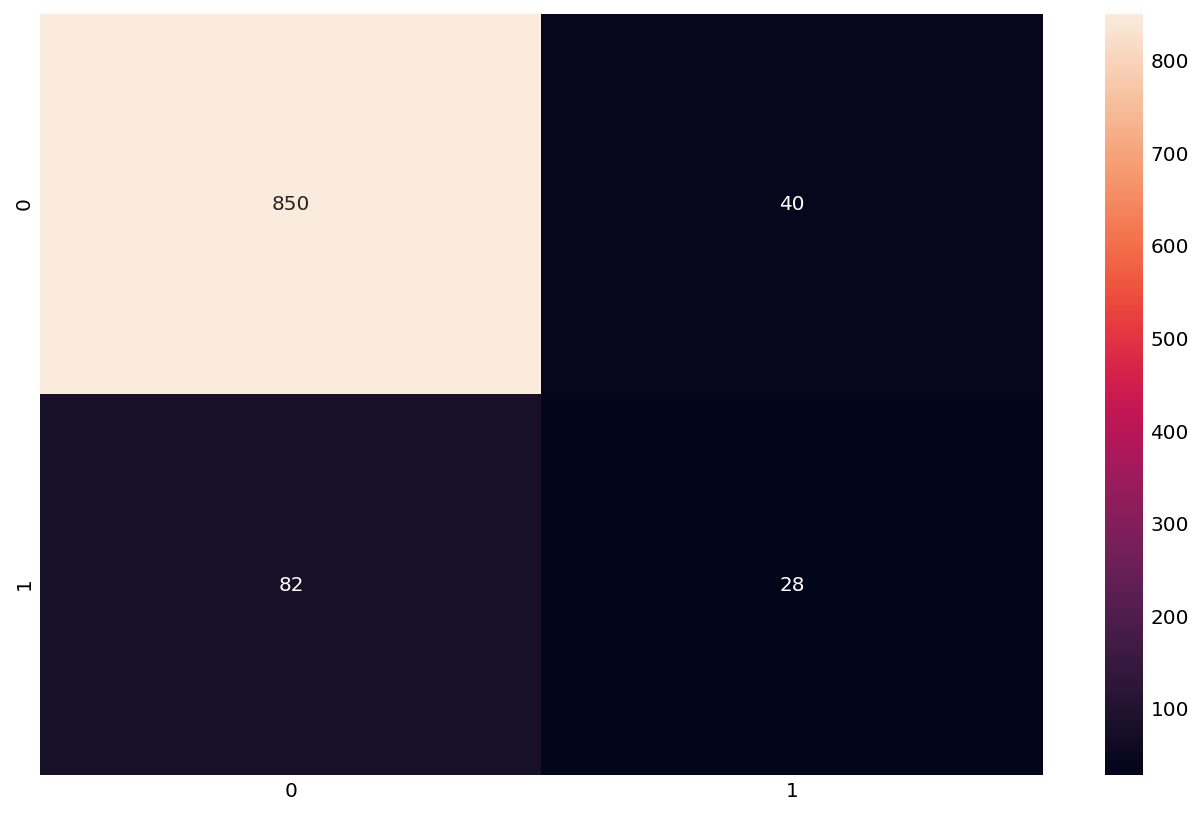

In [ ]:
# Model
model_CNN_TOXIC = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_CNN_TOXIC.add(e)

model_CNN_TOXIC.add(Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu', strides=1))
model_CNN_TOXIC.add(MaxPooling1D())

model_CNN_TOXIC.add(Flatten())
model_CNN_TOXIC.add(Dense(64, activation='relu'))
model_CNN_TOXIC.add(Dropout(0.77))

model_CNN_TOXIC.add(Dense(NUM_CLASSES, activation='softmax'))

model_CNN_TOXIC.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_CNN_TOXIC.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_CNN_TOXIC
history = MODEL.fit(x_train_seq, labels_train_Toxicity,
                          validation_data=(x_val_seq, labels_val_Toxicity),
                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Toxicity)
print("")
y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Toxicity.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Toxicity)
print(classification_report(y_true, y_pred, digits = 4))

### LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 80, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                67840     
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 2,072,130
Trainable params: 2,072,130
Non-trainable params: 0
____________________________________________

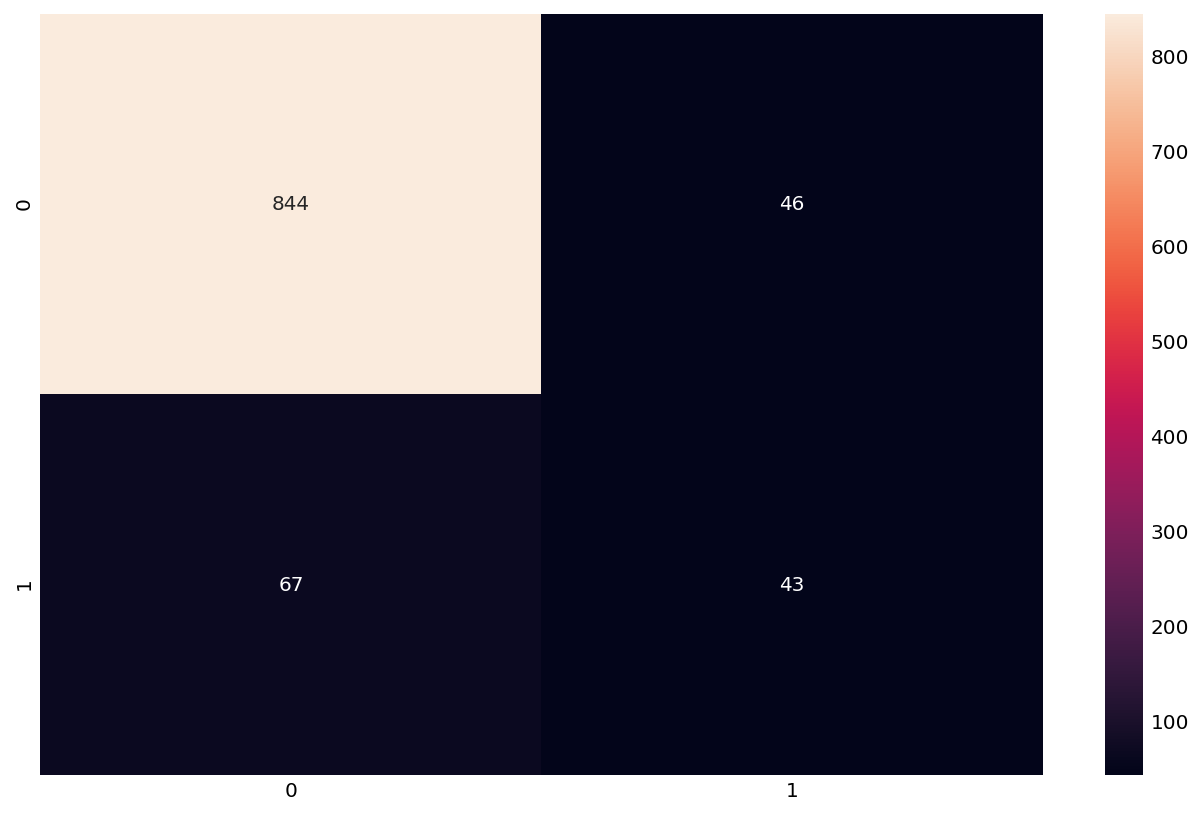

In [ ]:
# Model
model_LSTM_TOXIC = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_LSTM_TOXIC.add(e)

model_LSTM_TOXIC.add(LSTM(64))

model_LSTM_TOXIC.add(Flatten())
model_LSTM_TOXIC.add(Dense(64, activation='relu'))
model_LSTM_TOXIC.add(Dropout(0.77))

model_LSTM_TOXIC.add(Dense(NUM_CLASSES, activation='softmax'))

model_LSTM_TOXIC.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_LSTM_TOXIC.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_LSTM_TOXIC
history = MODEL.fit(x_train_seq, labels_train_Toxicity,
                          validation_data=(x_val_seq, labels_val_Toxicity),
                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Toxicity)
print("")
y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Toxicity.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Toxicity)
print(classification_report(y_true, y_pred, digits = 4))

### BiLSTM

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 80, 200)           2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               135680    
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 2,144,066
Trainable params: 2,144,066
Non-trainable params: 0
____________________________________________

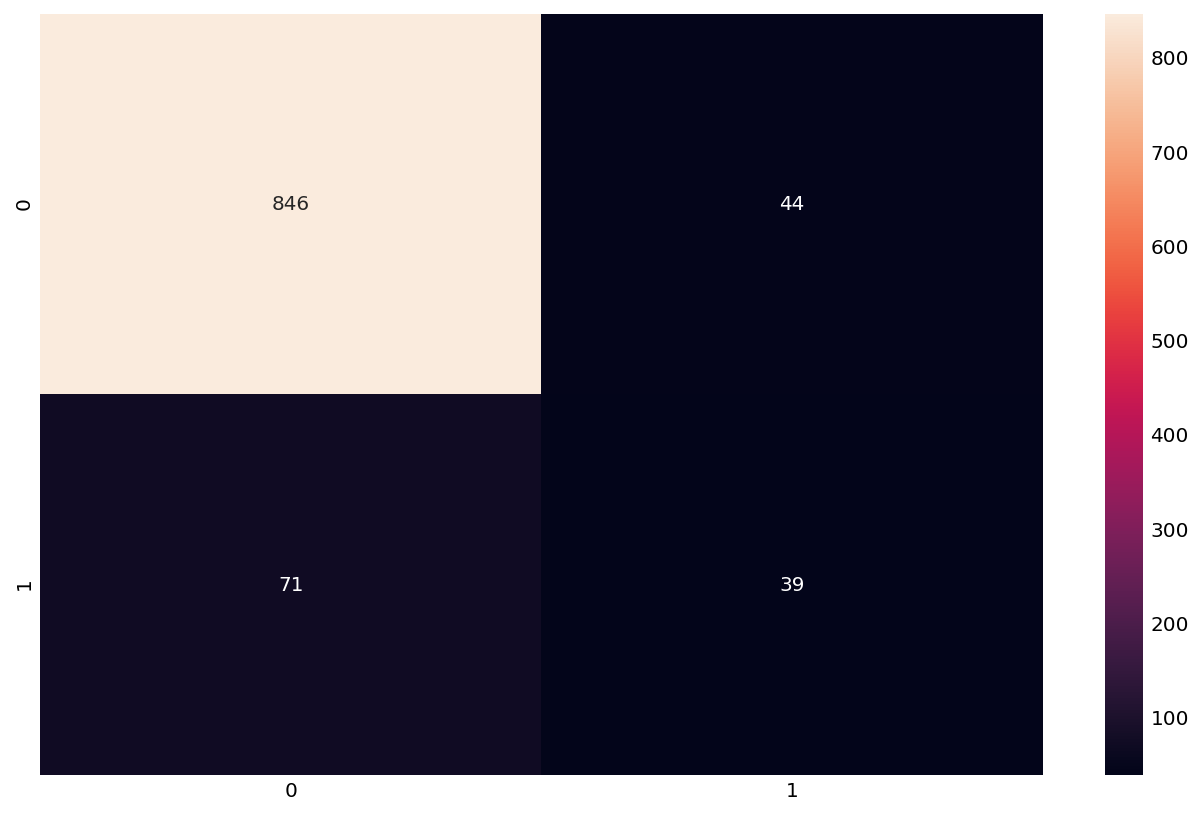

In [ ]:
# model_BiLSTM
model_BiLSTM_TOXIC = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_BiLSTM_TOXIC.add(e)

model_BiLSTM_TOXIC.add(Bidirectional(LSTM(64)))

model_BiLSTM_TOXIC.add(Flatten())
model_BiLSTM_TOXIC.add(Dense(64, activation='relu'))
model_BiLSTM_TOXIC.add(Dropout(0.77))

model_BiLSTM_TOXIC.add(Dense(NUM_CLASSES, activation='softmax'))

model_BiLSTM_TOXIC.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_BiLSTM_TOXIC.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_BiLSTM_TOXIC
history = MODEL.fit(x_train_seq, labels_train_Toxicity,
                          validation_data=(x_val_seq, labels_val_Toxicity),
                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Toxicity)
print("")
y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Toxicity.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Toxicity)
print(classification_report(y_true, y_pred, digits = 4))

### GRU

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 80, 200)           2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                51072     
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 2,055,362
Trainable params: 2,055,362
Non-trainable params: 0
____________________________________________

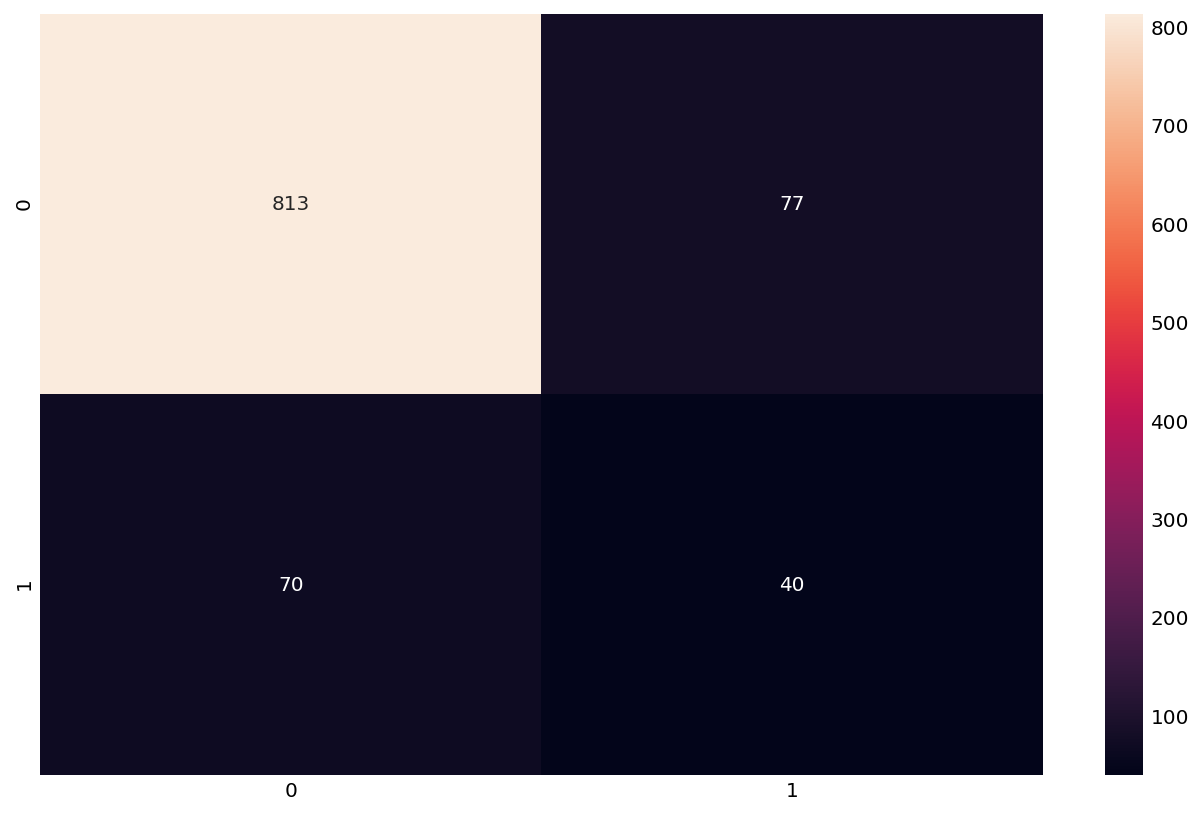

In [ ]:
# model_GRU
model_GRU_TOXIC = Sequential()

e = Embedding(10000, 200, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)
model_GRU_TOXIC.add(e)

model_GRU_TOXIC.add(GRU(64))

model_GRU_TOXIC.add(Flatten())
model_GRU_TOXIC.add(Dense(64, activation='relu'))
model_GRU_TOXIC.add(Dropout(0.77))

model_GRU_TOXIC.add(Dense(NUM_CLASSES, activation='softmax'))

model_GRU_TOXIC.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc', f1_m, precision_m, recall_m])

model_GRU_TOXIC.summary()
# ========================================================================================
EPOCHS = 10
BATCH_SIZE = 40
MODEL = model_GRU_TOXIC
history = MODEL.fit(x_train_seq, labels_train_Toxicity,
                          validation_data=(x_val_seq, labels_val_Toxicity),
                          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
# ========================================================================================
print("\n-- MODEL's RESULTS --")
show_results_on_test(MODEL, x_test_seq, labels_test_Toxicity)
print("")
y_pred = MODEL.predict(x_test_seq)
matrix = metrics.confusion_matrix(labels_test_Toxicity.argmax(axis=1), y_pred.argmax(axis=1))
plot_confusion_matrix(matrix, num_classes = NUM_CLASSES)

y_true, y_pred = inference(MODEL, x_test_seq, labels_test_Toxicity)
print(classification_report(y_true, y_pred, digits = 4))

# **III. DEMO**

## 1.Demo Contructiveness

In [ ]:
test_Constructiveness_df

,Comment,Constructiveness
0,Người ăn không hết kẻ lần chẳng ra,0
1,Nhiều người cứ nghĩ đạp xe là văn minh. haizzzz,0
2,Rất văn hoá,0
3,Đời ta ba mươi đời nó. Mua chiếc xe cũng chỉ p...,0
4,"Tước bằng lái vĩnh viễn đi. Chạy lếu láo thật,...",1
...,...,...
995,biệt thự nhà riêng to đùng thế kia mà chủ (hay...,0
996,"Trong cái khó ló cái khôn, người tài thật sự k...",0
997,Bánh trung thu sao lại phải có quả trứng muối ...,0
998,Cấp 1 nói chung và lớp 1 nói riêng theo tôi có...,1


In [ ]:
single_inference(MODEL = model_CNN)

Nhập câu: Tôi thấy hay đó 
Label của câu này là:  0


In [ ]:
single_inference(MODEL = model_LSTM)

Nhập câu: Tước bằng lái vĩnh viễn đi. Chạy lếu láo thật
Label của câu này là:  0


In [ ]:
single_inference(MODEL = model_BiLSTM)

Nhập câu: Rất văn hoá
Label của câu này là:  0


In [ ]:
single_inference(MODEL = model_GRU)

Nhập câu: Rất văn hoá
Label của câu này là:  0


## 2.Demo Toxicity

In [ ]:
test_Toxicity_df

,Comment,Toxicity
0,Người ăn không hết kẻ lần chẳng ra,1
1,Nhiều người cứ nghĩ đạp xe là văn minh. haizzzz,1
2,Rất văn hoá,0
3,Đời ta ba mươi đời nó. Mua chiếc xe cũng chỉ p...,0
4,"Tước bằng lái vĩnh viễn đi. Chạy lếu láo thật,...",1
...,...,...
995,biệt thự nhà riêng to đùng thế kia mà chủ (hay...,1
996,"Trong cái khó ló cái khôn, người tài thật sự k...",0
997,Bánh trung thu sao lại phải có quả trứng muối ...,0
998,Cấp 1 nói chung và lớp 1 nói riêng theo tôi có...,0


In [ ]:
single_inference(MODEL = model_CNN_TOXIC)

Nhập câu: ủng hộ nha
Label của câu này là:  0


In [ ]:
single_inference(MODEL = model_LSTM_TOXIC)

Nhập câu: rất ủng hộ
Label của câu này là:  0


In [ ]:
single_inference(MODEL = model_BiLSTM_TOXIC)

Nhập câu: Rất văn hoá
Label của câu này là:  0


In [ ]:
single_inference(MODEL = model_GRU_TOXIC)

Nhập câu: Rất văn hoá
Label của câu này là:  0
